In [3]:
import pandas as pd
import numpy as np
from pyspark.sql import Row
from pyspark.sql import SparkSession

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
%cd

C:\Users\chris


In [4]:
from ast import literal_eval

In [5]:
movies = pd.read_csv('movies_metadata.csv', low_memory = False)

In [6]:
movies = movies.loc[:, ['id', 'genres']]
movies['genres'] = (
    movies['genres']
    .fillna('[]')
    .apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
)
movies.head()

,id,genres
0,862,"[Animation, Comedy, Family]"
1,8844,"[Adventure, Fantasy, Family]"
2,15602,"[Romance, Comedy]"
3,31357,"[Comedy, Drama, Romance]"
4,11862,[Comedy]


In [7]:
genres = set([item for row in movies['genres'].values for item in row])

In [8]:
for g in genres:
    movies[g] = 0

for row in range(movies.shape[0]):
    for g in movies.loc[row, 'genres']:
        movies.at[row, g] = 1
    
movies.head()

,id,genres,BROSTA TV,Telescene Film Group Productions,Rogue State,Fantasy,Animation,Science Fiction,TV Movie,Comedy,...,Aniplex,Foreign,Romance,Music,Odyssey Media,Pulser Productions,Crime,Action,Adventure,Western
0,862,"[Animation, Comedy, Family]",0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,8844,"[Adventure, Fantasy, Family]",0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,15602,"[Romance, Comedy]",0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
3,31357,"[Comedy, Drama, Romance]",0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
4,11862,[Comedy],0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [9]:
movies['genres_bitmap'] = movies.iloc[:, 2:].apply(lambda row : ''.join([str(x) for x in row]), axis = 1)
counts = movies['genres_bitmap'].value_counts()

counts = pd.DataFrame({
    'genres_bitmap' : counts.index,
    'genres_counts' : counts
})

# leave only the popular combinations of genres
counts = counts.loc[counts['genres_counts'] >= 10, :]
counts.shape

(359, 2)

In [10]:
movies = movies.merge(counts, on = 'genres_bitmap', how = 'inner')
movies.rename(columns = {'movie id' : 'movie_id'}, inplace = True)
movies['genreId'] = movies['genres_bitmap'].astype("category").cat.codes
movies['movieId'] = movies['id'].astype('int64')

movies.head()

,id,genres,BROSTA TV,Telescene Film Group Productions,Rogue State,Fantasy,Animation,Science Fiction,TV Movie,Comedy,...,Odyssey Media,Pulser Productions,Crime,Action,Adventure,Western,genres_bitmap,genres_counts,genreId,movieId
0,862,"[Animation, Comedy, Family]",0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,00001001000000000010000000000000,112,303,862
1,12233,"[Animation, Comedy, Family]",0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,00001001000000000010000000000000,112,303,12233
2,532,"[Family, Animation, Comedy]",0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,00001001000000000010000000000000,112,303,532
3,531,"[Animation, Comedy, Family]",0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,00001001000000000010000000000000,112,303,531
4,40688,"[Animation, Comedy, Family]",0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,00001001000000000010000000000000,112,303,40688


In [11]:
ratings = pd.read_csv('ratings_small.csv', low_memory=False)

In [12]:
ratings_genres = (
    ratings.loc[:, ['userId', 'movieId', 'rating']]
    .merge(movies.loc[:, ['movieId', 'genreId']], on = 'movieId', how = 'inner')
)

ratings_genres.head()

,userId,movieId,rating,genreId
0,1,1371,2.5,20
1,4,1371,4.0,20
2,7,1371,3.0,20
3,19,1371,4.0,20
4,21,1371,3.0,20


In [13]:
ratings_counts = (
    ratings_genres.groupby(['userId', 'genreId'], as_index = False)['movieId'].count()
    .rename(columns = {'movieId' : 'counts'})
)

ratings_counts.head()

,userId,genreId,counts
0,1,20,1
1,1,57,1
2,1,159,1
3,1,170,1
4,1,182,1


In [14]:
# sanity check
(
    ratings_genres
    .merge(ratings_counts, on = ['userId', 'genreId'], how = 'left')
    .sort_values(by = ['userId', 'genreId'])
).head(20)

,userId,movieId,rating,genreId,counts
0,1,1371,2.5,20,1
47,1,1405,1.0,57,1
182,1,2294,2.0,159,1
93,1,2105,4.0,170,1
235,1,2455,2.5,182,1
140,1,2193,2.0,185,1
4610,2,551,5.0,6,1
2431,2,314,4.0,9,1
822,2,153,4.0,20,7
1878,2,266,5.0,20,7


In [15]:
(
    ratings_genres
    .merge(ratings_counts, on = ['userId', 'genreId'], how = 'left')
    .loc[:, ['rating', 'counts']]
).corr()

,rating,counts
rating,1.000000,-0.066247
counts,-0.066247,1.000000


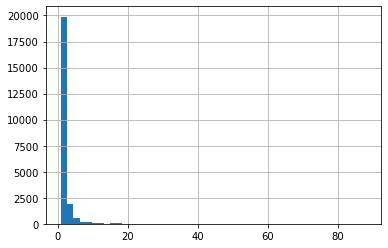

In [16]:
ratings_counts['counts'].hist(bins = 50)
plt.show()

In [17]:
from sklearn.model_selection import train_test_split

ratings_counts.dropna(axis = 0, inplace = True)
ratings.dropna(axis = 0, inplace = True)

ratings_train, ratings_test = train_test_split(ratings_counts, test_size = 0.2, random_state = 42)

In [18]:
import findspark
import pyspark
findspark.init()
findspark.find()

'C:\\spark\\spark-3.2.1-bin-hadoop3.2'

In [19]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
conf = pyspark.SparkConf().setAppName("testapp").setMaster("local")
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession(sc)

In [20]:
# exporting to Spark

train_df = spark.createDataFrame(ratings_train)
test_df = spark.createDataFrame(ratings_test)
ratings_df = spark.createDataFrame(ratings_genres)

In [21]:
sc

<SparkContext master=local appName=testapp>

In [22]:
spark

In [23]:
sc.setCheckpointDir('checkpoint/')

In [24]:
from pyspark.ml.recommendation import ALS

als = ALS(rank = 5, maxIter = 10, implicitPrefs = True, nonnegative = True,
          userCol = "userId", itemCol = "genreId", ratingCol = "counts", seed = 42)

In [25]:
mf = als.fit(train_df)
mf

ALSModel: uid=ALS_8882722fbfd3, rank=5